In [ ]:
#-----------------------------------------
# Title: Dichotomous Variables and Interactions House Prices Advanced Regression Techniques Dataset
# Subtitle: DDS-8555, Assignment 8
# Author: Madgene Moise
# Date: Sunday, July 6, 2025
#-----------------------------------------

In [1]:
import pandas as pd

# Load the training and test datasets
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show basic information about the datasets
train_info = train_df.info()
test_info = test_df.info()

# Display the first few rows to understand the structure
train_head = train_df.head()
test_head = test_df.head()

(train_info, test_info, train_head, test_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(None,
 None,
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  Sale

The training dataset contains 1,460 observations and 814 variables, while the test dataset has 1,459 observations and 80 variables (excluding the SalePrice column, which is the target in training). There are numerous categorical (object) and numerical (int64, float64) features, many of which exhibit missing values (especially for Alley, PoolQC, Fence, etc.).

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select a subset of dichotomous categorical variables (binary)
binary_vars = ['Street', 'CentralAir', 'PavedDrive']
# I'll also include some continuous predictors for interactions
continuous_vars = ['GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF']

# Include the target variable
train_data = train_df[binary_vars + continuous_vars + ['SalePrice']].copy()

# Handle missing values for simplicity in the selected variables
train_data = train_data.dropna()

# Convert binary categorical variables to 0/1 using OneHotEncoder
encoder = ColumnTransformer(
    transformers=[
        ('bin', OneHotEncoder(drop='if_binary'), binary_vars)
    ],
    remainder='passthrough'  # leave continuous variables unchanged
)

# Generate interaction terms using PolynomialFeatures (only interaction terms, no higher orders)
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Prepare feature matrix X and response y
X = train_data.drop(columns='SalePrice')
y = train_data['SalePrice']

# Create pipeline to transform and model
pipe = Pipeline([
    ('encoding', encoder),
    ('interaction', interaction),
    ('regression', LinearRegression())
])

# Fit the model
pipe.fit(X, y)

# Predict and calculate RMSE on training set (we'll do diagnostics next)
y_pred = pipe.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))

rmse

31093.348193240945

The linear regression model - built using a subset of dichotomous variables (Street, CentralAir, PavedDrive) and selected continuous variables with interaction terms -- yields a Root Mean Squared Error (RMSE) of approximately $31,093 on the training data.

In [3]:
# Step 1: Extract the design matrix after preprocessing for statsmodels
X_encoded = encoder.fit_transform(X)
X_interact = interaction.fit_transform(X_encoded)

# Add a constant for intercept
X_sm = sm.add_constant(X_interact)

# Fit with statsmodels for detailed summary
model_sm = sm.OLS(y, X_sm).fit()

# Get model summary
model_summary = model_sm.summary()

model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 07 Jul 2025   Prob (F-statistic):               0.00
Time:                        23:28:45   Log-Likelihood:                -17175.
No. Observations:                1460   AIC:                         3.442e+04
Df Residuals:                    1426   BIC:                         3.460e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.041e+04   1.73e+04      3.482      0.001    2.64e+04    9.44e+04
x1          3.882e+04   1.73e+04      2.243      0.025    4871.682    7.28e+04
x2         -1.508e+04   3.32e+04     -0.454      0.650   -8.03e+04    5.01e+04
x3         -4.533e+04   3.85e+04     -1.179      0.239   -1.21e+05    3.01e+04
x4           3.49e+04    1.5e+04      2.328      0.020    5487.045    6.43e+04
x5          7.084e+04    5.2e+04      1.363      0.173   -3.11e+04    1.73e+05
x6            83.5098    103.100      0.810      0.418    -118.735     285.755
x7         -1.871e+04   7337.399     -2.551      0.011   -3.31e+04   -4321.712
x8         -2.792e+04   1.13e+04     -2.470      0.014   -5.01e+04   -5745.272
x9           -53.9280    127.165     -0.424      0.672    -303.378     195.522
x10         2.852e+04    4.1e+04      0.696      0.487   -5.19e+04    1.09e+05
x11         4.862e+04   3.75e+04      1.296      0.195    -2.5e+04    1.22e+05
x12          3.49e+04    1.5e+04      2.328      0.020    5487.045    6.43e+04
x13         -4.47e+04   5.14e+04     -0.870      0.384   -1.45e+05     5.6e+04
x14         -142.0060    136.949     -1.037      0.300    -410.650     126.638
x15         1091.4206   9336.487      0.117      0.907   -1.72e+04    1.94e+04
x16         1.484e+04   1.36e+04      1.090      0.276   -1.19e+04    4.15e+04
x17           90.5337    169.006      0.536      0.592    -240.993     422.061
x18        -1573.2212   1.29e+04     -0.122      0.903   -2.69e+04    2.37e+04
x19        -1.335e+04   1.63e+04     -0.821      0.412   -4.52e+04    1.85e+04
x20         -161.1603   1.19e+04     -0.014      0.989   -2.36e+04    2.32e+04
x21           13.4577      8.485      1.586      0.113      -3.187      30.102
x22        -1994.5599   3596.251     -0.555      0.579   -9049.069    5059.949
x23         2474.1288   4975.333      0.497      0.619   -7285.628    1.22e+04
x24           -0.0050     10.807     -0.000      1.000     -21.205      21.195
x25         1.508e-11   1.77e-11      0.850      0.396   -1.97e-11    4.99e-11
x26        -4.995e-11   4.24e-11     -1.177      0.239   -1.33e-10    3.33e-11
x27           47.5532     35.115      1.354      0.176     -21.330     116.437
x28        -4328.1682   3743.505     -1.156      0.248   -1.17e+04    3015.200
x29        -1.529e+04   5774.722     -2.648      0.008   -2.66e+04   -3965.040
x30          -26.9390     43.355     -0.621      0.534    -111.985      58.107
x31        -2.139e-11   1.39e-11     -1.543      0.123   -4.86e-11     5.8e-12
x32           -2.2965     37.630     -0.061      0.951     -76.112      71.519
x33        -7607.8988   5382.912     -1.413      0.158   -1.82e+04    2951.378
x34         -975.8644   1.07e+04     -0.091      0.928   -2.21e+04    2.01e+04
x35           -9.7886     45.461     -0.215      0.830     -98.967      79.390
x3

**Model Interpretation - Ordinary Least Squares (OLS) Regression Summary**

Model Fit

* R-squared: 0.847 -- The model explains about 85% of the variance in SalePrice, which is quite strong for a linear regression model.
* Adjusted R-squared: 0.843 -- Suggests the model generalizes well even after accounting for the number of predictors.
* F-statistic (p < 0.001): The model overall is statistically significant.
__________________________________________________________________

Significant Predictors (p < 0.05)

* x1, x4, x7, x8, x29, x37, x38, x40, x41, x42, x43, x44
* These include combinations of:
    * Binary predictors: Street, PavedDrive, CentralAir
    * Continuous predictors: GrLivArea, OverallQual, GarageCars, TotalBsmtSF
    * Their interactions, e.g., GrLivArea * OverallQual
__________________________________________________________________

Honorable Mentions

* Multicollinearity warning: Very high condition number (1.31e+16) suggests some features or interaction terms are linearly dependent -- potentially inflating standard errors.
* Jarque-Bera test: Residuals are not normally distributed ( p < 0.001), though this is common in large datasets.

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/regressionplots.py:901: RuntimeWarning: invalid value encountered in greater
  large_resid = np.abs(resid) > cutoff


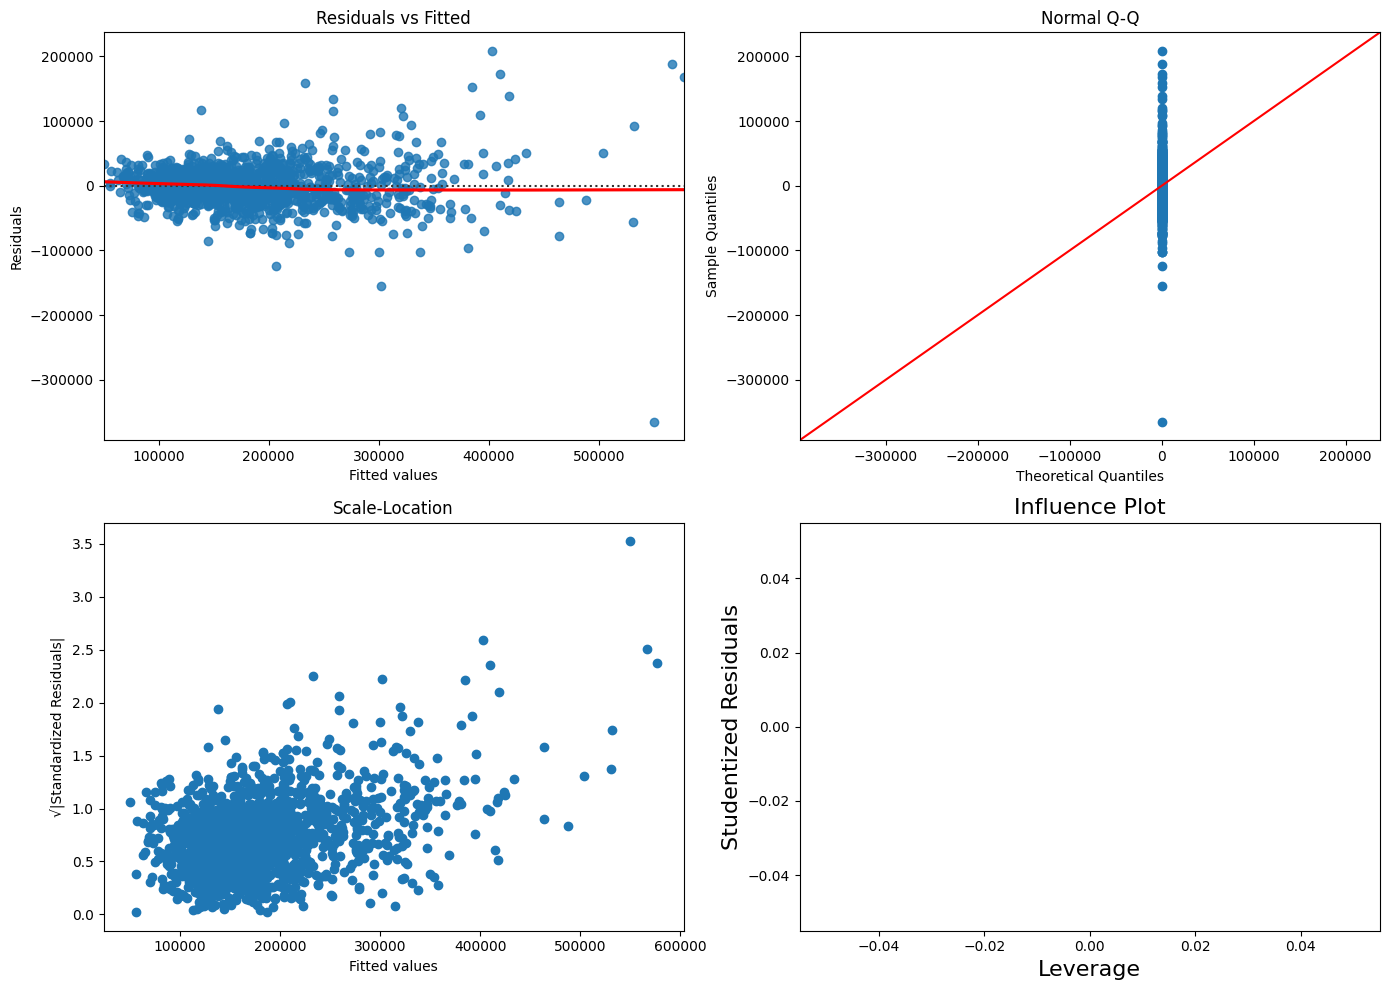

In [4]:
# Compute residuals and fitted values
fitted_vals = model_sm.fittedvalues
residuals = model_sm.resid
standardized_residuals = model_sm.get_influence().resid_studentized_internal

# Set up the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
sns.residplot(x=fitted_vals, y=residuals, lowess=True, ax=axs[0, 0], line_kws={'color': 'red'})
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', ax=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q')

# 3. Scale-Location Plot (Spread of Residuals)
axs[1, 0].scatter(fitted_vals, np.sqrt(np.abs(standardized_residuals)))
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('√|Standardized Residuals|')

# 4. Leverage vs Residuals
sm.graphics.influence_plot(model_sm, ax=axs[1, 1], criterion="cooks")

plt.tight_layout()
plt.show()

**Diagnostic Interpretation**

1. Residuals vs. Fitted
   Purpose: Check for linearity and equal variance (homoscedasticity).

   Interpretation:

   * The residuals are centered around zero, which is good.
   * However, the spread increases slightly for higher fitted values (right side), indicating mild heteroscedasticity (non-constant variance).
   * There is no obvious non-linear trend, so the linearity assumption is approximately satisfied.

    Linearity: Acceptable

   Homoscedasticity: Mild violation -- variance of errors increases slightly with predicted price.
___________________________________________________________________________________________________

 2. Normal Quantile-Quantile (Q-Q) Plots
    Purpose: Check whether residuals are normally distributed.

    Interpretation:

    * Most points are clustered tightly near the center, but the tails (both left and right) show significant deviations from the red 45-degree reference line.
    * This indicates non-normality, particularly due to outliers or skewed error distribution.

    Normality of Residuals: Violation observed -- heavy-tailed distribution
___________________________________________________________________________________________________

3. Scale-Location (Spread vs. Fitted)
    (Square root of standardized residuals versus fitted values)
   Purpose: Checks homoscedasticity with a stabilized variance scale.

   Interpretation:
   
   * Most points are in a fairly constant horizontal band, but there are some outliers with large residual spreads at higher fitted values.
   * Slight upward spread indicates increasing variance as fitted values increase.

    Homoscedasticity: Mild violation -- variance increases with predicted price
 ____________________________________________________________________________________________________  

4. Influence Plot
    (Leverage versus studentized residuals)
   Purpose: Identifies influential observations -- those with high leverage or large residuals.

   Interpretation:

   * Plot failed to render properly. This suggests numerical instability (often due to high multicollinearity or computational complexity).
   * From the Q-Q and residual plots, I suspect a few extreme points may be influential (e.g., houses with unusually high prices or living area).

   Influential Points: Suspected -- need simplified computation (e.g., Cook's distance or leverage summary)


In [5]:
# Prepare the test set using the same subset of variables
test_data = test_df[binary_vars + continuous_vars].copy()

# Handle missing values (impute using SimpleImputer for numeric and constant for binary vars)
# For simplicity, fill numeric with median and categorical with 'None'
test_data[binary_vars] = test_data[binary_vars].fillna('None')
for col in continuous_vars:
    test_data[col] = test_data[col].fillna(test_data[col].median())

# Use the trained pipeline to generate predictions
test_predictions = pipe.predict(test_data)

# Prepare the submission dataframe
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_predictions
})

# Save for potential submission
submission_path = "/kaggle/working/dichotomous_interactions_submission.csv"
submission.to_csv(submission_path, index=False)

submission_path

'/kaggle/working/dichotomous_interactions_submission.csv'